# Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.stats import skew, kurtosis
from sklearn.metrics.pairwise import pairwise_distances

# GLOBAL VARIABLES

# time horizon in years
T = 20  

# number of time steps
N = int(T * 252 * 7)  

# change remige's lenght
l_regime = int(0.5  * 252 * 7)

# time interval
dt = T / N

# GBM parameters
gbm_par = np.array(
    [[0.02, 0.2], #mu,sigma *bull-regime*
    [-0.02, 0.3]]) #mu,sigma *bear-regime*

# array of all the timesteps
timestep = np.linspace(0, T, N)

In [2]:
def data_par(h_1, h_2):
    '''
    Given the hyper parameters h_1 and h_2 it returns the number of sub-sequences M and the effective number of log-returns that
    are involved in the analysis N_prime.
    
    '''
    
    # check the number of possible sub sequences M
    i = 0
    # N - 2 (-1:from price to log-return and -1:becuase the last index is lenght of the array -1)
    while ((h_1 - h_2) * i + h_1) <= (N-2):
        i = i + 1

    # IMPORTANT parameters
    M = i 
    N_prime = (h_1 - h_2) * (M-1) + h_1 + 1
    
    return N_prime, M

h_1 = 35
h_2 = 28
N_prime, M = data_par(h_1, h_2)
t = timestep[: N_prime + 1]

print(f"price values not included in the analysis = {len(timestep) - len(t)}")

price values not included in the analysis = 5


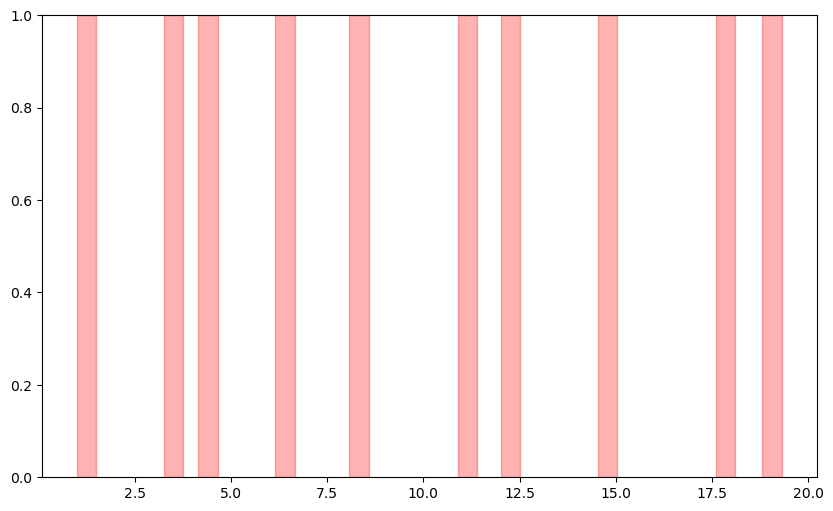

In [3]:
def generate_regimes(N_prime):
    '''
    It generates randomly 10 different time interval of the same same lenght.
    
    '''

    A = np.arange(0, N_prime+1)

    # Parametri delle sottosequenze
    num_subsequences = 10
    subseq_length = l_regime 

    # Set per memorizzare gli indici di partenza usati
    used_indices = set()

    # Funzione per generare un indice di partenza valido
    def generate_start_index(random_state=17):
        np.random.seed(random_state)
        while True:
            # Genera un indice di partenza casuale
            start_index = np.random.randint(0, len(A) - subseq_length - 1)
            # Controlla se l'indice di partenza e l'indice finale (con buffer di 1) sono validi
            if all((start_index + i) not in used_indices for i in range(subseq_length + 1)):
                for i in range(subseq_length + 1):
                    used_indices.add(start_index + i)
                return start_index

    # Generazione delle sottosequenze random non sovrapposte con almeno un elemento di distanza
    subsequences = []
    for _ in range(num_subsequences):
        start_index = generate_start_index()
        subsequences.append(A[start_index:start_index + subseq_length])

    subsequences = np.sort(np.array(subsequences), axis=0)
    
    # label for the log-returns
    B = np.zeros(N_prime)
    for sub in subsequences:
        B[sub[0]: sub[-1]] = 1    
    B = B.astype(int)

    # label for prices
    C = np.zeros(N_prime+1)
    for sub in subsequences:
        C[sub] = 1    
    C = C.astype(int)


    
    return subsequences, B, C

subsequences, theo_labels, labels_prices = generate_regimes(N_prime)

# plot of the regimes
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.axvspan(timestep[subsequences[i][0]], timestep[subsequences[i][-1]], color='red', alpha=0.3)
plt.show()

mean_path = 1.5904336169888507 
std_path = 0.8746807632129775


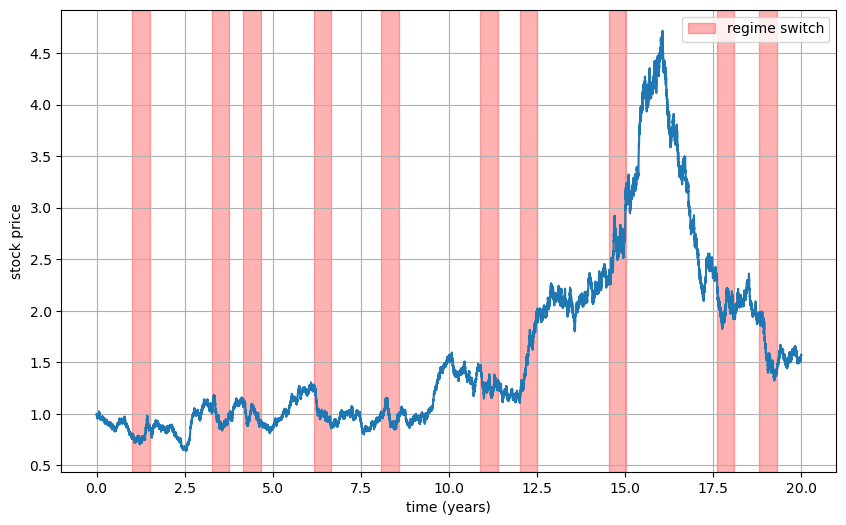

In [4]:
def gbm(S0, mu, sigma, n):
    """
    Simulates a Geometric Brownian Motion (GBM) by using the analytical solution.

    Parameters:
    S0 (float): Initial stock price
    mu (float): Drift coefficient
    sigma (float): Volatility coefficient
    T (float): Time horizon
    n (int): Number of time steps

    Returns:
    np.ndarray: Simulated stock prices

    """
    t = np.arange(1, n) * dt
    W = np.random.standard_normal(size=n-1) 
    W = np.cumsum(W) * np.sqrt(dt) # cumulative sum to simulate the Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = np.zeros(n)
    S[0] = S0
    S[1:] = S0 * np.exp(X)
    return S

def gbm_path(N_prime, C, t):
    '''
    It simulates the entire path of a GBM with regimes switch.
    
    '''
    # array of prices
    s = np.zeros(N_prime + 1)
    # initial stock price
    s[0] = 1
    s_0 = s[0]
    start_index = 0
    stop_index = 1

    for k in range(1, N_prime+1):
        if k == N_prime:
            s[start_index : stop_index + 1] = gbm(s_0, gbm_par[C[k]][0], gbm_par[C[k]][1], len(t[start_index : stop_index + 1]))

        elif C[k] == C[k+1]:
            stop_index = k+1

        else:
            s[start_index : stop_index + 1] = gbm(s_0, gbm_par[C[k]][0], gbm_par[C[k]][1], len(t[start_index : stop_index + 1]))
            #updates
            start_index = k
            s_0 = s[k]
            stop_index = k + 1
            
    return s

# to ensure reproducibility
np.random.seed(15)

# relevant time series
prices = gbm_path(N_prime, labels_prices, t)  
log_returns = np.diff(np.log(prices))

print(f'mean_path = {np.mean(prices)} \nstd_path = {np.std(prices)}')

# plot price path
plt.figure(figsize=(10, 6))
plt.plot(t,prices)
for i in range(10):
    if i == 0:
        plt.axvspan(t[subsequences[i][0]], t[subsequences[i][-1]], color='red', alpha=0.3, label='regime switch')
        
    else:
        plt.axvspan(t[subsequences[i][0]], t[subsequences[i][-1]], color='red', alpha=0.3)
        
    
#plt.title("Geometric Brownian Motion Simulation")
plt.xlabel("time (years)")
plt.ylabel("stock price")
plt.grid()
plt.legend()
plt.show()
plt.show()

In [5]:
def lift_function(h_1, h_2, log_returns, M):
    '''
    It returns a matrix (and the sorted version) in which the rows are the subsequences.
    
    '''

    # creation of the sub-sequences
    lift_matrix = np.ndarray((M, h_1 + 1))

    for j in range(0, M):
        lift_matrix[j] = log_returns[(h_1 - h_2) * j : (h_1 - h_2) * j + h_1 + 1]

    sorted_lift_matrix = np.sort(lift_matrix)
    return lift_matrix, sorted_lift_matrix

lift_matrix, sorted_lift_matrix = lift_function(h_1, h_2, log_returns, M)
X_wasserstein = sorted_lift_matrix

print(f'number of sub sequences = {M}')

number of sub sequences = 5035


# WK-means

In [50]:
# I would find a more suitable way to set the parameter p....
P = 7

def p_wasserstein_distance(x, y, p=P):
    return np.sum(np.abs(x - y) ** p)


class WassersteinKMeans:
    def __init__(self, n_clusters=2, p=P, max_iter=600, tol=1e-8, random_state=None):
        self.n_clusters = n_clusters
        self.p = p
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        # n_atoms represents the number of atoms for the empirical cdf
        n_samples, n_atoms = X.shape

        # Initialize cluster centers
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.cluster_centers_ = X[indices]

        for i in range(self.max_iter):
            # Compute distances and assign clusters
            distances = pairwise_distances(X, self.cluster_centers_, metric=p_wasserstein_distance)
            labels = np.argmin(distances, axis=1)

            # Compute new cluster centers
            new_centers = np.array([np.median(X[labels == j] ,axis=0) for j in range(self.n_clusters)])
            # just to be sure that the new centroids are ordered sequences
            new_centers.sort()
            
            # Check for convergence
            loss = 0
            for j in range(self.n_clusters):
                loss = loss + p_wasserstein_distance(self.cluster_centers_[j], new_centers[j])
            if loss < self.tol:
#                 print(loss)
                break

            self.cluster_centers_ = new_centers

        self.labels_ = labels
        return self

    def predict(self, X):
        distances = pairwise_distances(X, self.cluster_centers_, metric=p_wasserstein_distance)
        return np.argmin(distances, axis=1)


True


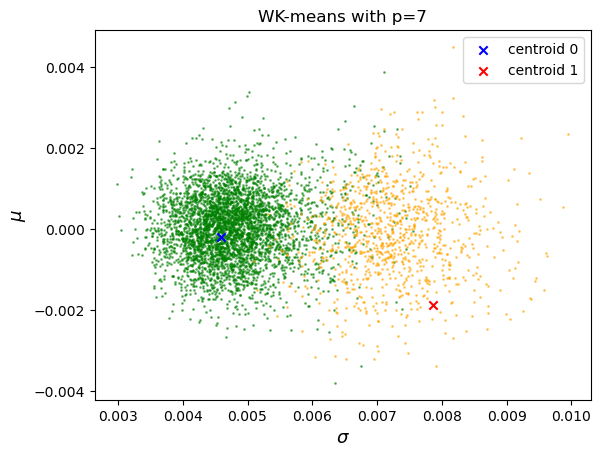

Wall time: 374 ms


In [51]:
%%time
# Fit the Wasserstein KMeans
wkmeans = WassersteinKMeans(random_state=30)
wkmeans.fit(X_wasserstein)

# Predict cluster labels of sub-sequences
sub_labels = wkmeans.predict(X_wasserstein)
print((wkmeans.labels_ == sub_labels).all())

# off-regime->lower variance
off_regime_index = 0 
# on-regime->higher variance
on_regime_index = 1 
# check regime
if np.var(wkmeans.cluster_centers_, axis=1)[0] > np.var(wkmeans.cluster_centers_, axis=1)[1]:
    off_regime_index = 1
    on_regime_index = 0


# scatter plot of empirical cdf
point_size = 4
plt.scatter(
    np.std(X_wasserstein[wkmeans.labels_ == off_regime_index], axis=1),
    np.mean(X_wasserstein[wkmeans.labels_ == off_regime_index], axis=1),
    marker='.', color='green', alpha=0.5, s=point_size)
plt.scatter(
    np.std(X_wasserstein[wkmeans.labels_ == on_regime_index], axis=1),
    np.mean(X_wasserstein[wkmeans.labels_ == on_regime_index], axis=1),  
    marker='.', color='orange', alpha=0.5, s=point_size)
# scatter plot of centroids
plt.scatter(np.std(wkmeans.cluster_centers_, axis=1)[off_regime_index],
            np.mean(wkmeans.cluster_centers_, axis=1)[off_regime_index],
            color='blue', marker='x', label='centroid 0')
plt.scatter(np.std(wkmeans.cluster_centers_, axis=1)[on_regime_index],
            np.mean(wkmeans.cluster_centers_, axis=1)[on_regime_index],
            color='red', marker='x', label='centroid 1')

plt.xlabel(f'$\sigma$', size=13)
plt.ylabel(f'$\mu$', size=13)
plt.title(f'WK-means with p={P}')
plt.legend()
# PAY ATTENTION
# plt.savefig('figure/2_w_means_29_gbm_15_ite_300_tol_4.pdf', bbox_inches='tight')
plt.show()

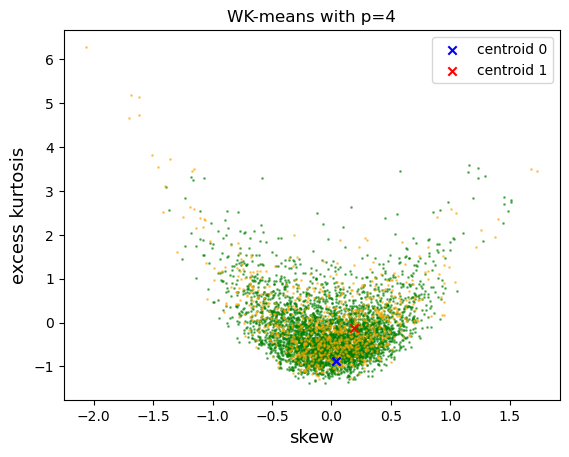

In [47]:
# scatter plot of empirical cdf
point_size = 4
plt.scatter(
    skew(X_wasserstein[wkmeans.labels_ == off_regime_index], axis=1),
    kurtosis(X_wasserstein[wkmeans.labels_ == off_regime_index], axis=1),
    marker='.', color='green', alpha=0.5, s=point_size)
plt.scatter(
    skew(X_wasserstein[wkmeans.labels_ == on_regime_index], axis=1),
    kurtosis(X_wasserstein[wkmeans.labels_ == on_regime_index], axis=1),  
    marker='.', color='orange', alpha=0.5, s=point_size)
# scatter plot of centroids
plt.scatter(skew(wkmeans.cluster_centers_, axis=1)[off_regime_index],
            kurtosis(wkmeans.cluster_centers_, axis=1)[off_regime_index],
            color='blue', marker='x', label='centroid 0')
plt.scatter(skew(wkmeans.cluster_centers_, axis=1)[on_regime_index],
            kurtosis(wkmeans.cluster_centers_, axis=1)[on_regime_index],
            color='red', marker='x', label='centroid 1')

plt.xlabel(f'skew', size=13)
plt.ylabel(f'excess kurtosis', size=13)
plt.title(f'WK-means with p={P}')
plt.legend()
plt.show()

# Accuracy scores

In [50]:
%%time
r_counter = np.zeros((len(log_returns), 2))

for k in range(len(log_returns)):
    for j in range(M):

        if k - (h_1 - h_2) * j >= 0 and k - (h_1 - h_2) * j <= h_1:

            if wkmeans.labels_[j] == 0:
                r_counter[k][0] += 1
            else:
                r_counter[k][1] += 1
                
                
s_counter = np.zeros((len(prices), 2))

for j in range(len(prices)):

    if j == 0 :
        s_counter[j][0] = r_counter[j][0]
        s_counter[j][1] = r_counter[j][1]

    elif j == (len(prices) - 1) :
        s_counter[j][0] = r_counter[j-1][0]
        s_counter[j][1] = r_counter[j-1][1]

    else:
        s_counter[j][0] = r_counter[j][0] + r_counter[j-1][0]
        s_counter[j][1] = r_counter[j][1] + r_counter[j-1][1]


Wall time: 53.6 s


In [9]:
# optimization of the previous code by using ChatGPT
def opt_counter(kmeans, n, M, h_1, h_2):


    # Define the time indices for the sliding window
    time_indices = np.arange(n)[:, None] - (h_1 - h_2) * np.arange(M)[None, :]

    # Mask invalid indices
    valid_mask = (time_indices >= 0) & (time_indices <= h_1)

    # Use the valid_mask to filter time indices
    filtered_time_indices = time_indices * valid_mask

    # Create the labels array, repeated across all k for efficient processing
    labels_repeated = np.tile(kmeans.labels_, (n, 1))

    # Use the valid mask to apply the labels where indices are valid
    filtered_labels = np.where(valid_mask, labels_repeated, -1)

    # Count occurrences of each label
    r_counter_0 = np.sum(filtered_labels == 0, axis=1)
    r_counter_1 = np.sum(filtered_labels == 1, axis=1)

    # Combine the counts into a single array
    r_counter = np.stack((r_counter_0, r_counter_1), axis=1)
    
    # Initialize s_counter with the same shape as r_counter
    s_counter = np.zeros((n+1, 2))

    # Handle the first element
    s_counter[0] = r_counter[0]

    # Handle the last element
    s_counter[-1] = r_counter[-1]

    # For all other elements, sum the current and previous elements
    s_counter[1:-1] = r_counter[:-1] + r_counter[1:]

    
    return r_counter, s_counter


In [32]:
%%time
r_counter, s_counter = opt_counter(wkmeans, len(log_returns), M, h_1, h_2)
# # check
# a, b = opt(wkmeans, len(prices), M, h_1, h_2)
# print((a == r_counter).all())
# print((b == s_counter).all())

# regime-off accuracy score (ROFS)
ROFS = np.sum(r_counter[theo_labels == 0].T[off_regime_index])/np.sum(r_counter[theo_labels == 0])
print(f'ROFS = {round(ROFS, 3)}')

# regime-off accuracy score (ROFS)
RONS = np.sum(r_counter[theo_labels == 1].T[on_regime_index])/np.sum(r_counter[theo_labels == 1])
print(f'RONS = {round(RONS, 3)}')

# total accuracy (TA)
TA = (np.sum(r_counter[theo_labels == 0].T[off_regime_index]) + np.sum(r_counter[theo_labels == 1].T[on_regime_index]))/np.sum(r_counter)
print(f'TA = {round(TA, 3)}')

ROFS = 0.986
RONS = 0.841
TA = 0.95
Wall time: 2.51 s


In [34]:
%%time
r_counter, s_counter = opt_counter(wkmeans, len(log_returns), M, h_1, h_2)
# # check
# a, b = opt(wkmeans, len(prices), M, h_1, h_2)
# print((a == r_counter).all())
# print((b == s_counter).all())

# regime-off accuracy score (ROFS)
ROFS = np.sum(r_counter[theo_labels == 0].T[off_regime_index])/np.sum(r_counter[theo_labels == 0])
print(f'ROFS = {round(ROFS, 3)}')

# regime-off accuracy score (ROFS)
RONS = np.sum(r_counter[theo_labels == 1].T[on_regime_index])/np.sum(r_counter[theo_labels == 1])
print(f'RONS = {round(RONS, 3)}')

# total accuracy (TA)
TA = (np.sum(r_counter[theo_labels == 0].T[off_regime_index]) + np.sum(r_counter[theo_labels == 1].T[on_regime_index]))/np.sum(r_counter)
print(f'TA = {round(TA, 3)}')

ROFS = 0.493
RONS = 0.561
TA = 0.51
Wall time: 2.63 s


# dependence by the seed

In [87]:
# WARNING: run again if you change: the price path (log_returns), X_wasserstein, M, h_1, h_2, r_counter, theo_labels !
# in general if you change somenthing in Data preparation !!!

def wk_means_function(random_seed):

    wkmeans = WassersteinKMeans(random_state=random_seed)
    wkmeans.fit(X_wasserstein)

    # off-regime->lower variance
    off_regime_index = 0 
    # on-regime->higher variance
    on_regime_index = 1 
    # check regime
    if np.var(wkmeans.cluster_centers_, axis=1)[0] > np.var(wkmeans.cluster_centers_, axis=1)[1]:
        off_regime_index = 1
        on_regime_index = 0

    r_counter = opt_counter(wkmeans, len(log_returns), M, h_1, h_2)[0]

    # regime-off accuracy score (ROFS)
    ROFS = np.sum(r_counter[theo_labels == 0].T[off_regime_index])/np.sum(r_counter[theo_labels == 0])

    # regime-off accuracy score (ROFS)
    RONS = np.sum(r_counter[theo_labels == 1].T[on_regime_index])/np.sum(r_counter[theo_labels == 1])

    # total accuracy (TA)
    TA = (np.sum(r_counter[theo_labels == 0].T[off_regime_index]) + np.sum(r_counter[theo_labels == 1].T[on_regime_index]))/np.sum(r_counter)
    
    return ROFS, RONS, TA


In [50]:
# it's alone to avoid problem when I only want to import the data!
n_trials = 50

In [1]:
def convert_seconds(seconds):
    minutes = int(seconds // 60)
    remaining_seconds = seconds % 60
    return f"{minutes} min {int(remaining_seconds)} seconds"

In [93]:
rofs = np.zeros(n_trials)
rons = np.zeros(n_trials)
ta = np.zeros(n_trials)
iteration_times = np.zeros(n_trials)

start_time_tot = time.time()
for i in range(n_trials):
    # start
    start_time = time.time()
    # real computation
    rofs[i], rons[i], ta[i] = wk_means_function(i+1)
    # end
    end_time = time.time()
    # save data
    iteration_times[i] = end_time - start_time
end_time_tot = time.time()

input_seconds = float(end_time_tot - start_time_tot)
print(f'time to complete all the iterations = {convert_seconds(input_seconds)}')

time to complete all the iterations = 159.8070204257965 seconds


In [96]:
# print the results as txt file

df = pd.DataFrame({
    'ROFS': rofs,
    'RONS': rons,
    'TA': ta,
    'RUNTIME': iteration_times
})

# check the valuse of the parameters below! 
# REMINDER:
# p=2, wkmeans(w), accuracy scores, path = gbm, seed of the fixed path = 15, n_trials=50, max_ite = 600, tol=1e-8
# name of the file = 'numerical_results/2_w_accuracy_scores_gbm_15_n_50_ite_600_tol_8.txt'

df.to_csv('numerical_results_stability/2_w_accuracy_scores_gbm_15_n_50_ite_500_tol_7.txt', index=False)

In [55]:
# read the results
df = pd.read_csv('numerical_results_stability/2_w_accuracy_scores_gbm_20_n_50_ite_600_tol_8.txt')

rofs = df['ROFS'].values
rons = df['RONS'].values
ta = df['TA'].values
iteration_times = df['RUNTIME'].values

In [94]:
print(f'ROFS = {np.mean(rofs)} +- {np.std(rofs)}')
print(f'ROFS_max = {np.max(rofs)} \nROFS_min = {np.min(rofs)}')

print(f'\nRONS = {np.mean(rons)} +- {np.std(rons)}')
print(f'RONS_max = {np.max(rons)} \nRONS_min = {np.min(rons)}')

print(f'\nTA = {np.mean(ta)} +- {np.std(ta)}')
print(f'TA_max = {np.max(ta)} \nTA_min = {np.min(ta)}')

print(f'\nRUN TIME = {np.mean(iteration_times)} +- {np.std(iteration_times)} seconds')

ROFS = 0.937947642900751 +- 0.10292036275608152
ROFS_max = 0.9686872476112717 
ROFS_min = 0.45973181513927813

RONS = 0.9128870643801453 +- 0.09893728530477232
RONS_max = 0.9438742854620494 
RONS_min = 0.4646758922068463

TA = 0.9316833278163963 +- 0.1011913979852436
TA_max = 0.9585953878406709 
TA_min = 0.4957023060796646

RUN TIME = 3.196120433807373 +- 0.2984370135360488 seconds


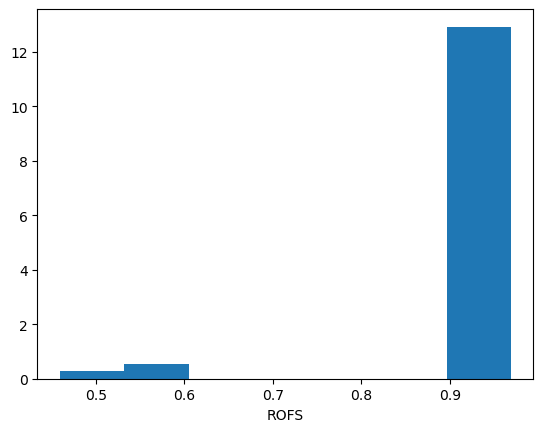

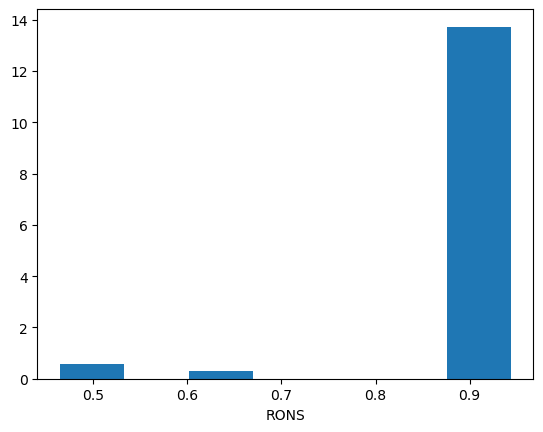

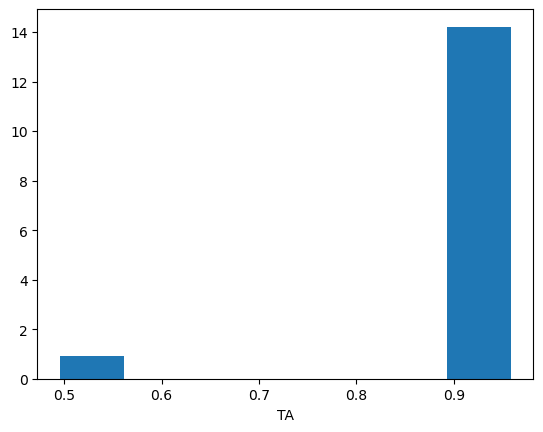

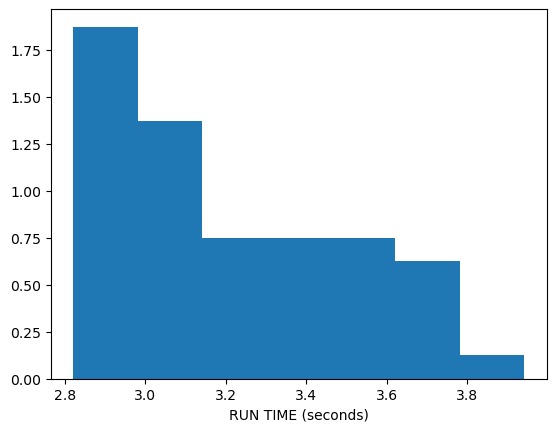

In [95]:
nn_bins = int(np.sqrt(n_trials))
# nn_bins = n_trials

plt.figure(1)
plt.hist(rofs, bins=nn_bins, density=True)
plt.xlabel('ROFS')

plt.figure(2)
plt.hist(rons, bins=nn_bins, density=True)
plt.xlabel('RONS')

plt.figure(3)
plt.hist(ta, bins=nn_bins, density=True)
plt.xlabel('TA')

plt.figure(4)
plt.hist(iteration_times, bins=nn_bins, density=True)
plt.xlabel('RUN TIME (seconds)')

plt.show()

# histograms

In [13]:
#formulas from the theory
theo_mean_bull = (gbm_par[0][0] - (gbm_par[0][1]**2)/2)*dt
theo_mean_bear = (gbm_par[1][0] - (gbm_par[1][1]**2)/2)*dt

theo_variance_bull = (gbm_par[0][1]**2)*dt
theo_variance_bear = (gbm_par[1][1]**2)*dt

theo_std_bull = np.sqrt(theo_variance_bull)
theo_std_bear = np.sqrt(theo_variance_bear)

# print values
print(f"mean bull = {theo_mean_bull}")
print(f"variance bull = {theo_variance_bull}")

print(f"\nmean centroid 0 = {np.mean(wkmeans.cluster_centers_, axis=1)[off_regime_index]}")
print(f"variance centroid 0 = {np.var(wkmeans.cluster_centers_, axis=1)[off_regime_index]}")


print(f"\nmean bear = {theo_mean_bear}")
print(f"variance bear = {theo_variance_bear}")

print(f"\nmean centroid 1 = {np.mean(wkmeans.cluster_centers_, axis=1)[on_regime_index]}")
print(f"variance centroid 1 = {np.var(wkmeans.cluster_centers_, axis=1)[on_regime_index]}")


mean bull = -1.9668066621052235e-21
variance bull = 2.267573696145125e-05

mean centroid 0 = 3.811854236137792e-05
variance centroid 0 = 2.0778482545449396e-05

mean bear = -3.684807256235828e-05
variance bear = 5.102040816326531e-05

mean centroid 1 = -3.772727428260023e-05
variance centroid 1 = 4.639779363994878e-05


### histogram of the mean

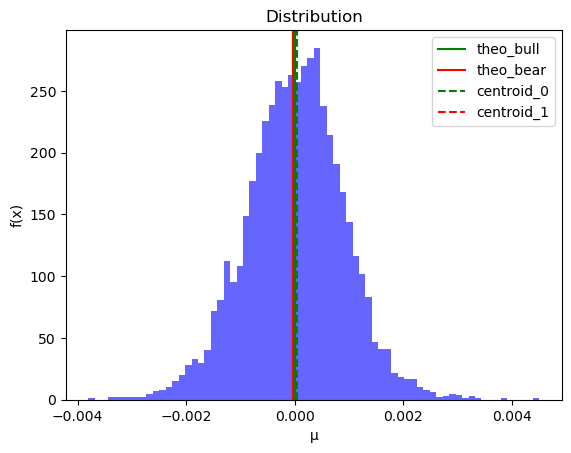

In [14]:
# Generate some sample data
data = np.mean(lift_matrix, axis=1)
n_bins = int(np.sqrt(M))
# Create the histogram
plt.hist(data, bins=n_bins, alpha=0.6, color='b') 

# Add vertical lines
plt.axvline(x=theo_mean_bull, color='green', linestyle='-', label='theo_bull')
plt.axvline(x=theo_mean_bear, color='red', linestyle='-', label='theo_bear')
plt.axvline(x=np.mean(wkmeans.cluster_centers_, axis=1)[off_regime_index], color='green', linestyle='--', label='centroid_0')
plt.axvline(x=np.mean(wkmeans.cluster_centers_, axis=1)[on_regime_index], color='red', linestyle='--', label='centroid_1')

# Add labels and legend
plt.title('Distribution')
plt.xlabel('μ')
plt.ylabel('f(x)')
plt.legend()

# Show the plot
plt.show()

### histogram of the std

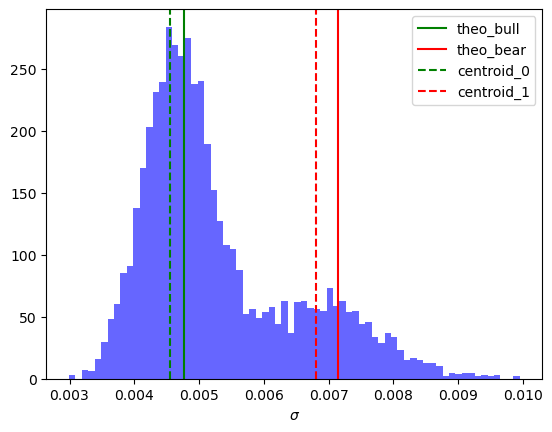

In [15]:
# Generate some sample data
data = np.std(lift_matrix, axis=1)
n_bins = int(np.sqrt(M))
# Create the histogram
plt.hist(data, bins=n_bins, alpha=0.6, color='b')  

# Add vertical lines
plt.axvline(x=theo_std_bull, color='green', linestyle='-', label='theo_bull')
plt.axvline(x=theo_std_bear, color='red', linestyle='-', label='theo_bear')
plt.axvline(x=np.std(wkmeans.cluster_centers_, axis=1)[off_regime_index], color='green', linestyle='--', label='centroid_0')
plt.axvline(x=np.std(wkmeans.cluster_centers_, axis=1)[on_regime_index], color='red', linestyle='--', label='centroid_1')

# Add labels and legend
plt.xlabel(f'$\sigma$')
# plt.ylabel('f(x)')
plt.legend()

# Show the plot
plt.show()

# CLUSTERING VALIDATION
to compute this value I need to compact all I have done in a single function

In [14]:
def clustering_validation(h_1 = 35, h_2 = 28, n_runs = 50):
    
    rofs = np.zeros(n_runs)
    rons = np.zeros(n_runs)
    ta = np.zeros(n_runs)
    iteration_times = np.zeros(n_runs)
    
    N_prime, M = data_par(h_1, h_2)
    t = timestep[: N_prime + 1]
    subs, theo_labels, price_labels = generate_regimes(N_prime)
    
    for j in range(n_runs): 
        # data preparation
        np.random.seed(j)
        log_returns = np.diff(np.log(gbm_path(N_prime, price_labels, t)))
        X_wasserstein = lift_function(h_1, h_2, log_returns, M)[1]
#         print(np.mean(log_returns), np.std(log_returns))
        # clustering
        start = time.time()
        
        wkmeans = WassersteinKMeans(random_state=30)
        wkmeans.fit(X_wasserstein)
        
        # off-regime->lower variance
        off_regime_index = 0 
        # on-regime->higher variance
        on_regime_index = 1 
        # check regime
        if np.var(wkmeans.cluster_centers_, axis=1)[0] > np.var(wkmeans.cluster_centers_, axis=1)[1]:
            off_regime_index = 1
            on_regime_index = 0
            
        # counter   
        r_counter = opt_counter(wkmeans, N_prime, M, h_1, h_2)[0]

        # regime-off accuracy score (ROFS)
        rofs[j] = np.sum(r_counter[theo_labels == 0].T[off_regime_index])/np.sum(r_counter[theo_labels == 0])

        # regime-off accuracy score (ROFS)
        rons[j] = np.sum(r_counter[theo_labels == 1].T[on_regime_index])/np.sum(r_counter[theo_labels == 1])

        # total accuracy (TA)
        ta[j] = (np.sum(r_counter[theo_labels == 0].T[off_regime_index]) + np.sum(r_counter[theo_labels == 1].T[on_regime_index]))/np.sum(r_counter)
        
        iteration_times[j] = time.time() - start

    return rofs, rons, ta, iteration_times

In [52]:
%%time
rofs, rons, ta, iteration_times = clustering_validation(n_runs = 50)
print(f"ROFS = {round(np.mean(rofs), 2)} -+ {round(np.std(rofs), 2)}")
print(f"RONS = {round(np.mean(rons), 2)} -+ {round(np.std(rons), 2)}")
print(f"TA = {round(np.mean(ta), 2)} -+ {round(np.std(ta), 2)}")
print(f"RUN TIME = {round(np.mean(iteration_times), 2)} -+ {round(np.std(iteration_times), 2)}")

ROFS = 0.87 -+ 0.22
RONS = 0.74 -+ 0.21
TA = 0.83 -+ 0.16
RUN TIME = 2.66 -+ 0.06
Wall time: 2min 13s


In [53]:
# print the results as txt file

df = pd.DataFrame({
    'ROFS': rofs,
    'RONS': rons,
    'TA': ta,
    'RUNTIME': iteration_times
})

# check the valuse of the parameters below! 
# REMINDER:
# p=2, wkmeans(w), h=h_1,h_2, path = gbm, seed of the clustering = 30, n_trials=50, max_ite = 600, tol=1e-8
# name of the file = 'numerical_results/2_w_35_28_gbm_15_n_50_ite_600_tol_8.txt'

df.to_csv('numerical_results/7_w_means_h_35_28_gbm_30_n_50_ite_600_tol_8.txt', index=False)

In [44]:
# read the results
df = pd.read_csv('numerical_results/2_w_means_h_35_28_gbm_30_n_50_ite_600_tol_8.txt')

rofs = df['ROFS'].values
rons = df['RONS'].values
ta = df['TA'].values
iteration_times = df['RUNTIME'].values

print(f"ROFS = {round(np.mean(rofs), 2)} -+ {round(np.std(rofs), 2)}")
print(f"RONS = {round(np.mean(rons), 2)} -+ {round(np.std(rons), 2)}")
print(f"TA = {round(np.mean(ta), 2)} -+ {round(np.std(ta), 2)}")
print(f"RUN TIME = {round(np.mean(iteration_times), 2)} -+ {round(np.std(iteration_times), 2)}")

ROFS = 0.96 -+ 0.01
RONS = 0.93 -+ 0.01
TA = 0.96 -+ 0.01
RUN TIME = 3.02 -+ 0.16


## Maximum Mean Discrepancy

in linea di principio viene impiegata come tool di validazione per dati reali, sui quali non abbiamo informazioni a priori. <br>
**Issues:**
- a pagina 17 viene fatta un'osservazione che sinceramente non ho capito...
- non viene specificato come estrarre gli elementi appartenenti ai clusters (samples with/without replacement...)

cosa devo fare?
- prendere in input due array (rappresentano le realizzazioni delle due misure empiriche) e calcolare la MMD associata

In [16]:
# Number of samples from a cluster
n_samples = 10000

In [19]:
def compute_mmd(x, y, sigma=0.1):
    n = len(x)
    m = len(y)

    # Compute the MMD terms
    K_xx = np.exp(-np.square(x[:, np.newaxis] - x[np.newaxis, :]) / (2 * sigma ** 2))
    K_xy = np.exp(-np.square(x[:, np.newaxis] - y[np.newaxis, :]) / (2 * sigma ** 2))
    K_yy = np.exp(-np.square(y[:, np.newaxis] - y[np.newaxis, :]) / (2 * sigma ** 2))

    # Compute the MMD terms using matrix operations
    term1 = np.sum(K_xx) / (n * n)
    term2 = np.sum(K_xy) / (m * n)
    term3 = np.sum(K_yy) / (m * m)

    # MMD^2 is the square of the difference
    mmd_squared = term1 - 2 * term2 + term3

    # Return the square root of the MMD^2
    return np.sqrt(mmd_squared)


### between-cluster similarity

In [17]:
def between_cluster_sim(n, matrix, kmeans):
    mmd_bet_array = np.zeros(n)

    # Number of elements in each cluster
    k_off = len(matrix[kmeans.labels_ == off_regime_index])
    k_on = len(matrix[kmeans.labels_ == on_regime_index])

    # Samples from cluster OFF
    np.random.seed(42)
    random_indexes_off = np.random.randint(0, k_off, size=n)
    subs_off = matrix[kmeans.labels_ == off_regime_index][random_indexes_off]

    # Samples from cluster ON
    np.random.seed(43)  # You can keep the seed consistent or change it if desired
    random_indexes_on = np.random.randint(0, k_on, size=n)
    subs_on = matrix[kmeans.labels_ == on_regime_index][random_indexes_on]

    # Calculate MMD for each sample pair
    for i, (x, y) in enumerate(zip(subs_off, subs_on)):
        mmd_bet_array[i] = compute_mmd(x, y)
        
    return mmd_bet_array

between SIM 1= 0.011440276493412536


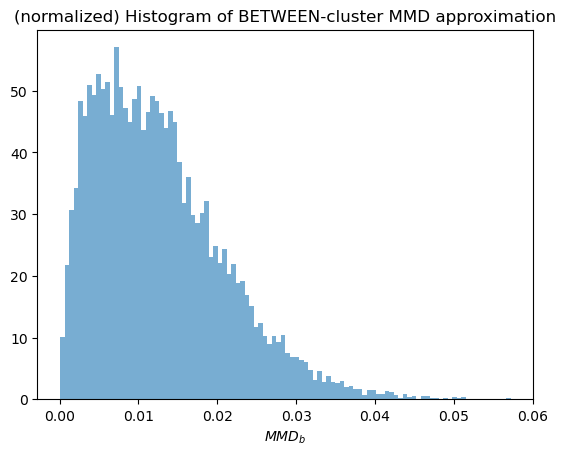

In [47]:
mmd_bet_array_1 = between_cluster_sim(n_samples, lift_matrix, wkmeans)
print(f"between SIM 1= {np.median(mmd_bet_array_1)}")
plt.hist(mmd_bet_array_1, bins=int(np.sqrt(len(mmd_bet_array_1))), density=True, alpha=0.6)
plt.title("(normalized) Histogram of BETWEEN-cluster MMD approximation")
plt.xlabel("$MMD_{b}$")
plt.show()

between SIM bad = 0.011440276493412536
between SIM good = 0.009774081477557709


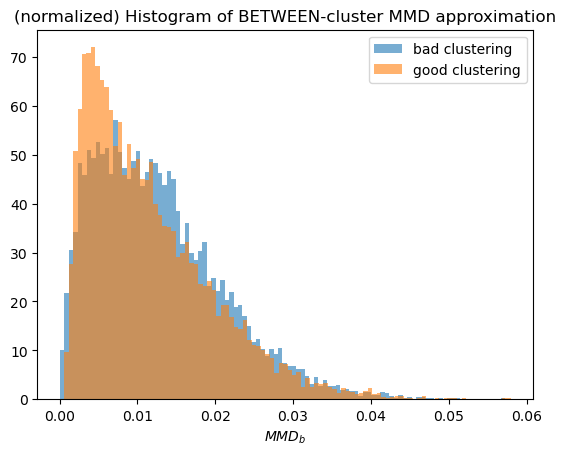

In [53]:
mmd_bet_array = between_cluster_sim(n_samples, lift_matrix, wkmeans)
print(f"between SIM bad = {np.median(mmd_bet_array_1)}")
print(f"between SIM good = {np.median(mmd_bet_array)}")

plt.hist(mmd_bet_array_1, bins=int(np.sqrt(len(mmd_bet_array_1))), density=True, alpha=0.6, label='bad clustering')
plt.hist(mmd_bet_array, bins=int(np.sqrt(len(mmd_bet_array))), density=True, alpha=0.6, label='good clustering')


plt.title("(normalized) Histogram of BETWEEN-cluster MMD approximation")
plt.xlabel("$MMD_{b}$")
plt.legend()
plt.show()

### inter-cluster similarity

In [23]:
def inter_cluster_sim(n, matrix, kmeans, c):
    k = len(matrix[kmeans.labels_ == c])
    # number of pairs from a cluster
    mmd_array = np.zeros(n)
    np.random.seed(42)
    # random indexes
    random_indexes = np.random.randint(0, k, size=int(n*2))

    # samples 0
    subs_0 = matrix[kmeans.labels_ == c][random_indexes[::2]]

    # samples 1
    subs_1 = matrix[kmeans.labels_ == c][random_indexes[1::2]]

    # calculate MMD for each sample pair
    for i, (x, y) in enumerate(zip(subs_0, subs_1)):
        mmd_array[i] = compute_mmd(x, y)

    return mmd_array

int_sim_off = 0.005959420356855698 
int_sim_on = 0.006575528351969787


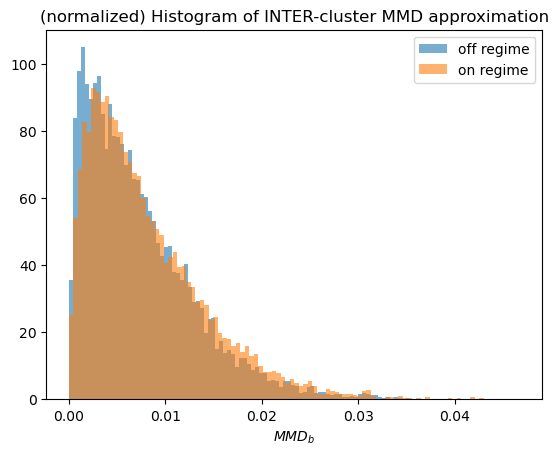

In [48]:
mmd_inter_array_off = inter_cluster_sim(n_samples, lift_matrix, wkmeans, off_regime_index)
mmd_inter_array_on = inter_cluster_sim(n_samples, lift_matrix, wkmeans, on_regime_index)

print(f"int_sim_off = {np.median(mmd_inter_array_off)} \nint_sim_on = {np.median(mmd_inter_array_on)}")
plt.hist(mmd_inter_array_off, bins=int(np.sqrt(n_samples)), density=True, alpha=0.6, label='off regime')
plt.hist(mmd_inter_array_on, bins=int(np.sqrt(n_samples)), density=True, alpha=0.6, label='on regime')
plt.title("(normalized) Histogram of INTER-cluster MMD approximation")
plt.xlabel("$MMD_{b}$")
plt.legend()
plt.show()

int_sim_off = 0.007595802394219595 
int_sim_on = 0.010748643279038536


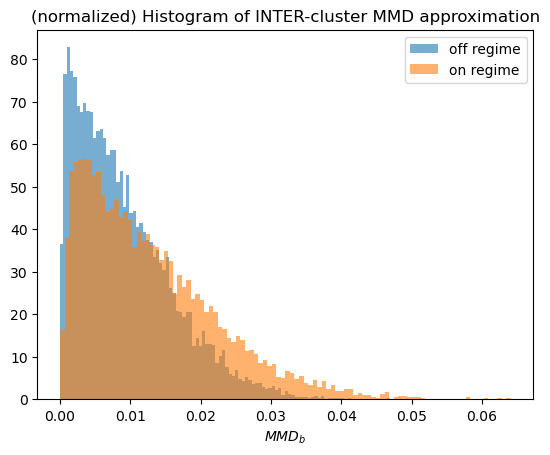

In [54]:
mmd_inter_array_off = inter_cluster_sim(n_samples, lift_matrix, wkmeans, off_regime_index)
mmd_inter_array_on = inter_cluster_sim(n_samples, lift_matrix, wkmeans, on_regime_index)

print(f"int_sim_off = {np.median(mmd_inter_array_off)} \nint_sim_on = {np.median(mmd_inter_array_on)}")
plt.hist(mmd_inter_array_off, bins=int(np.sqrt(n_samples)), density=True, alpha=0.6, label='off regime')
plt.hist(mmd_inter_array_on, bins=int(np.sqrt(n_samples)), density=True, alpha=0.6, label='on regime')
plt.title("(normalized) Histogram of INTER-cluster MMD approximation")
plt.xlabel("$MMD_{b}$")
plt.legend()
plt.show()

## prices clustering and price path
it may be a bit ambiguous... the paper is not so clear about the clustering on the prices data. This problem is clearly related to the visualization of different regimes on the price path

In [72]:
# two important functions to allow a correct way to plot data

def compare_columns(A):
    B = np.where(A[:, 0] > A[:, 1], 0, np.where(A[:, 0] < A[:, 1], 1, 2))
    return B

def plot_regimes(s_label, real_prices, real_t, y_label='stock price'):
    
    if not 2 in compare_columns(s_label):
        print('no ambiguos clustering')
        
    else:
        print('ambiguos clustering')
        
    pippo = 0
    pluto = 0
    supp_0 = 0
    supp_1 = 0
    supp_2 = 0
    
    b = compare_columns(s_label)

    plt.figure(figsize=(10, 6))
    for j in range(len(real_prices)):



        if j == (len(real_prices)-1):

            if b[j] == 0:
                plt.plot(real_t[pluto: pippo+1],real_prices[pluto: pippo+1],
                         color='green')

            elif b[j] == 1:
                plt.plot(real_t[pluto: pippo+1], real_prices[pluto: pippo+1],
                         color='red')  
                
            elif b[j] == 2:
                plt.plot(real_t[pluto: pippo+1], real_prices[pluto: pippo+1],
                         color='blue') 

        elif b[j] == b[j+1]:
            pippo = j+1


        else:
            if b[j] == 0:
                
                if supp_0 == 0:
                    plt.plot(real_t[pluto: pippo+1],real_prices[pluto: pippo+1],
                             color='green', label='regime 0')
                    pluto = j+1
                    supp_0 += 1
                else:
                    
                    plt.plot(real_t[pluto: pippo+1],real_prices[pluto: pippo+1],
                             color='green')
                    pluto = j+1
                    

            elif b[j] == 1:
                if supp_1 == 0:
                    plt.plot(real_t[pluto: pippo+1],real_prices[pluto: pippo+1],
                             color='red', label='regime 1')
                    pluto = j+1
                    supp_1 += 1
                else:
                    
                    plt.plot(real_t[pluto: pippo+1],real_prices[pluto: pippo+1],
                             color='red')
                    pluto = j+1
                
            elif b[j] == 2:
                if supp_2 == 0:
                    plt.plot(real_t[pluto: pippo+1],real_prices[pluto: pippo+1],
                             color='blue', label='both regimes')
                    pluto = j+1
                    supp_2 += 1
                else:
                    
                    plt.plot(real_t[pluto: pippo+1],real_prices[pluto: pippo+1],
                             color='blue')
                    pluto = j+1
                    
                    
    for i in range(10):
        if i == 0:
            plt.axvspan(real_t[real_subsequences[i][0]], real_t[real_subsequences[i][-1]],
                        color='red', alpha=0.3, label='regime switch')

        else:
            plt.axvspan(real_t[real_subsequences[i][0]], real_t[real_subsequences[i][-1]], color='red', alpha=0.3)

    plt.legend()
    plt.xlabel('years')
    plt.ylabel(y_label)
    plt.show()        

In [73]:
# compact function

def path_prices_clustering(real_log_returns, real_prices, real_t, kmeans, h_1, h_2):

    r_counter = np.zeros((len(real_log_returns), 2))

    for k in range(len(real_log_returns)):
        for j in range(M):

            if k - (h_1 - h_2) * j >= 0 and k - (h_1 - h_2) * j <= h_1:

                if kmeans.labels_[j] == 0:
                    r_counter[k][0] += 1
                else:
                    r_counter[k][1] += 1

    r_counter_ratio = (r_counter.T /np.sum(r_counter, axis=1)).T

    r_label = np.zeros_like(r_counter_ratio)
    r_label[r_counter_ratio == np.max(r_counter_ratio, axis=1, keepdims=True)] = 1

    s_counter = np.zeros((len(real_prices), 2))

    for j in range(len(real_prices)):

        if j == 0 :
            s_counter[j][0] = r_counter[j][0]
            s_counter[j][1] = r_counter[j][1]

        elif j == (len(real_prices) - 1) :
            s_counter[j][0] = r_counter[j-1][0]
            s_counter[j][1] = r_counter[j-1][1]

        else:
            s_counter[j][0] = r_counter[j][0] + r_counter[j-1][0]
            s_counter[j][1] = r_counter[j][1] + r_counter[j-1][1]


    s_counter_ratio = (s_counter.T /np.sum(s_counter, axis=1)).T

    s_label = np.zeros_like(s_counter_ratio)
    s_label[s_counter_ratio == np.max(s_counter_ratio, axis=1, keepdims=True)] = 1

    # in compare_columns(s_label) 2 means that a price belongs to two different regime
    plot_regimes(s_label, real_prices, real_t)


no ambiguos clustering


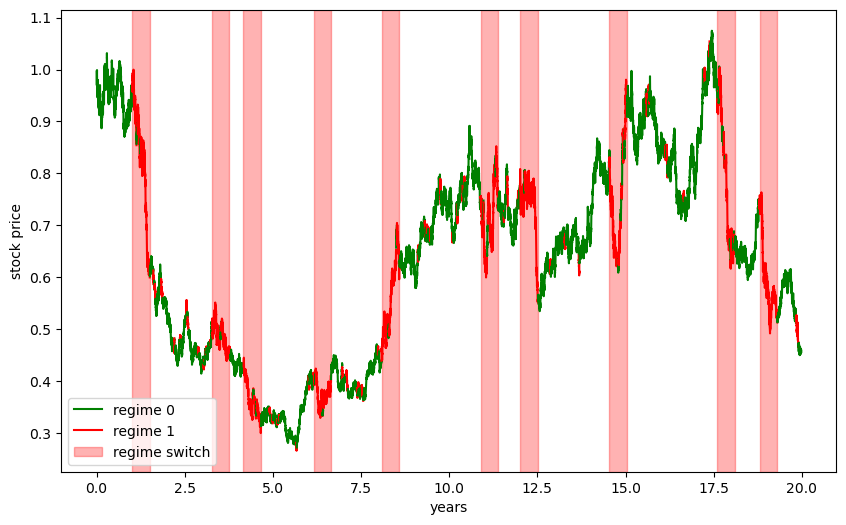

Wall time: 6.9 s


In [90]:
%%time
# WK-means
path_prices_clustering(log_returns, prices, t, wkmeans, h_1, h_2)